In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.integrate import quad

import lilguys as lguys
from lilguys import units as lu
import arya
from glob import glob as glob


In [83]:
params = lguys.gravity.params_en(1, 1, 10)

In [84]:
plt.plot(r, M / M[-1])

NameError: name 'M' is not defined

In [92]:
np.tanh(0-1)

-0.7615941559557649

In [100]:
np.arctanh(np.linspace(0.01, 0.99, 10000))

array([0.01000033, 0.01009835, 0.01019637, ..., 2.636897  , 2.64175116,
       2.64665241])

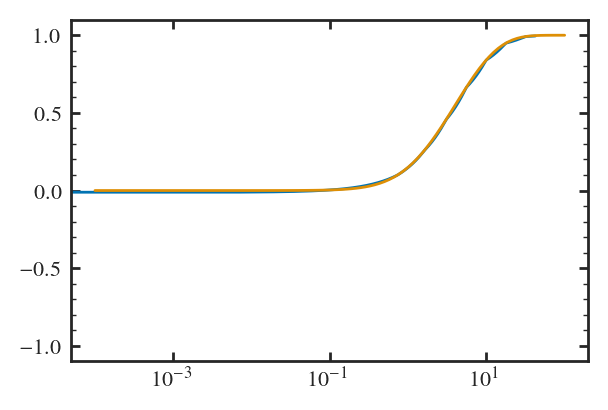

In [124]:
r = np.logspace(-4, 2, 100)

#plt.plot(r, lguys.gravity.M_en(r, params)/lguys.gravity.M_en(r[-1], params))

M = np.tanh(np.linspace(-3, 3, 10000))
plt.plot(lguys.gravity.inverse_M_en(params, N_eval=1_0)(M), M)

M = [quad(lambda x: 4*np.pi * x**2 * lguys.gravity.rho_en(x, params), 0, x)[0] for x in r]
M = np.array(M)

plt.plot(r, M/M[-1])
plt.xscale('log')

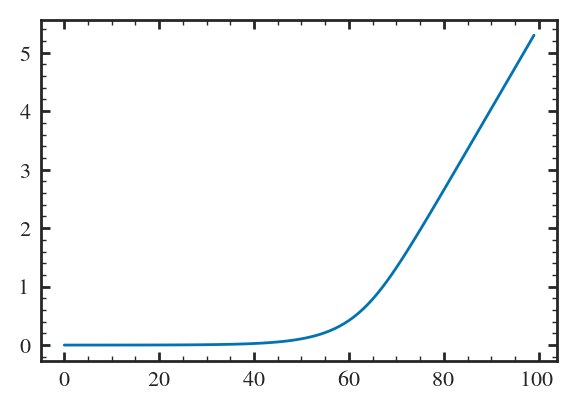

In [114]:
plt.plot(np.arcsinh(r))

In [33]:
from scipy.integrate import quad

In [74]:
N = 100_000
pos = lguys.gravity.rand_pos_en(params, Neval=10000, Npoints=N)

In [75]:
vel = np.zeros(pos.shape)
snap = lguys.Snapshot(pos, vel, m=1/N)
prof = lguys.profile.Profile(snap, r_bins=50)

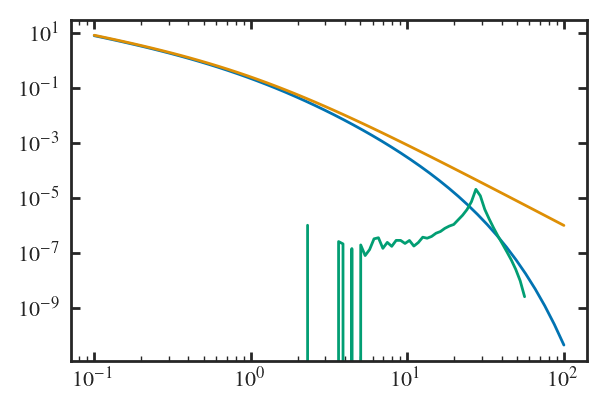

In [76]:
r = np.logspace(-1, 2)
plt.plot(r, lguys.gravity.rho_en(r, params))
plt.plot(r, lguys.gravity.rho_nfw(r, params))
plt.plot(prof.r, prof.nu_DM)
plt.xscale('log')
plt.yscale('log')

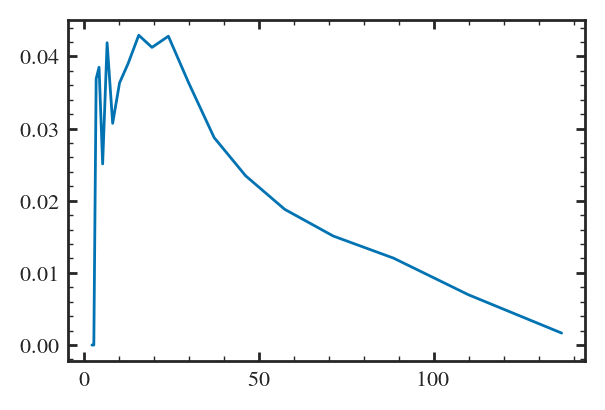

In [ ]:
from scipy.interpolate

In [3]:
asya_fornax1_vmax_x = [-10.230335175684273, -9.972075577696813, -9.694814153881742, -9.289827413851505, -8.954321263043102, -8.566105699721582, -7.98035376442693, -7.4644955015242775, -6.863459488933502, -6.441205872390347, -5.848101056666749, -5.445097115853306, -4.944688163514843, -4.404210143670327, -3.8797597508282324, -3.37538520005618, -2.8509348072140854, -2.2484116952107147, -1.8492081195627925, -1.256681620277428, -0.7329747771416297, -0.2630513627613791, 0.3408762320205536, 0.7667649804611649]
asya_fornax1_vmax_y = [39.788822260618176, 39.502433625820146, 38.97437634809319, 38.16512518209845, 37.590089327054464, 36.61279940373344, 36.04724960757078, 35.95216316021276, 35.80558096464185, 35.680455330826305, 35.481473952863325, 34.67945026030198, 34.08815259003286, 34.24467256157469, 34.082280267868235, 34.04139987126063, 33.897753836772026, 33.37466544703052, 32.859933823446376, 32.936951587220925, 32.75197343903513, 32.79962959198654, 32.67902112906687, 32.35265553184041]

In [4]:
asya_fornax1_vhl_x = [-10.478035525587481, -10.09535550747245, -9.717455844613294, -9.401868531843876, -9.004931313842903, -8.585601905432831, -8.09163186232577, -7.594726513359834, -6.979150941813851, -6.4823294587296, -5.900635703383149, -5.522400576997266, -5.166473775138798, -4.694308861269058, -4.042000033546352, -3.4142639091564773, -2.7275700699441447, -2.11820057364263, -1.669014911353763, -1.259078481692077, -0.8091380264680712, -0.22576695348798204, 0.3419211996175715, 0.7413743940690054]
asya_fornax1_vhl_y = [13.741380699674222, 13.779138703104675, 14.111593318675247, 14.372952376567014, 14.62086590152989, 15.03086256316983, 15.120192473724803, 15.065489415096295, 15.135295675096984, 15.18207876227423, 15.271408672829203, 15.628175758901335, 15.830411308982491, 15.79394260323015, 15.889166446027927, 15.985127030356054, 15.884930182228413, 16.18036353589888, 16.234145667614452, 16.256063728142376, 16.35736568856554, 16.35736568856554, 16.470823884239486, 16.439512369199598]

In [5]:
asya_rho_dmi_x = [-0.9187524442706296, -0.7994860048047376, -0.688991005084083, -0.5664841611263199, -0.45872674451086654, -0.3383848259679312, -0.24515336052293424, -0.12267445108665288, -0.013646013743784569, 0.09876250069836304, 0.19237108218336219, 0.2974328174758366, 0.408276998715012, 0.5023185652829767, 0.5939856975250014, 0.693572266607073, 0.7862590088831778, 0.870286049499972, 0.9603190122353203, 1.0507570255321526, 1.1325074026481927, 1.2146209285434941, 1.2969858651321302]
asya_rho_dmi_y = [8.38707562171112, 8.30733922394715, 8.18196423009459, 8.082097014803036, 7.938001016376781, 7.808593301749152, 7.671972590613269, 7.529024114358781, 7.368403796659071, 7.209521155390895, 7.0693267323486495, 6.861461287519877, 6.707529384764184, 6.511139161653087, 6.33124047146768, 6.121866854641727, 5.932165046474648, 5.72577498729529, 5.509483451090966, 5.296437763315355, 5.0865395649251655, 4.85792036196128, 4.637104309765414]

asya_rho_dmf_x = [-0.8257165204760042, -0.7195374043242639, -0.6070031845354489, -0.50118721716297, -0.39855578523939883, -0.30419297167439524, -0.18668640706184703, -0.07730878820045813, 0.019679870383820325, 0.12267445108665288, 0.22400692776132744, 0.3256746186937818, 0.41333314710319013, 0.48903570031845356, 0.5707022738700486, 0.6463629253030896, 0.7210039667020504, 0.8051148108832895, 0.8892256550645288, 0.9836583049332365]
asya_rho_dmf_y = [8.11744069769348, 7.969082474057802, 7.9067884133046995, 7.796691857510533, 7.686431369977541, 7.50725397944296, 7.370436550220488, 7.200275405321224, 7.026704480254422, 6.838740348518877, 6.626579892132916, 6.396157440041966, 6.141440304257307, 5.893214865330076, 5.578629858526909, 5.194177144636973, 4.817593154210587, 4.356125309421157, 3.9660661300634414, 3.587449386075638]

In [135]:
out = lguys.Output("../mw_models/fornax/out")
out2 = lguys.Output("../mw_models/fornax/out2")
out3 = lguys.Output("../mw_models/fornax/out3")

In [4]:
snap_i = out[1]

In [37]:

def rho(snap, x):
    x = np.array(x)
    a = snap.epsilon
    r = lguys.gravity.dist(x.reshape(-1, 1, 3), snap.pos.reshape(1,-1,3))
    return 3*snap.m / (4*np.pi*a**3) * np.sum((1 + r**2 / a**2)**(-5/2), axis=-1)

In [6]:
p0, v0 = lguys.profile.get_center(snap_i)

In [68]:
N = 100
r = np.linspace(-20, 20, N)
x, y = np.meshgrid(r + p0[0], r + p0[1])
z = np.full(N**2, p0[2])


In [69]:
X = np.array([x.flatten(),y.flatten(),z.flatten()]).transpose()

In [72]:
snap_i.epsilon=0.01
density = rho(snap_i, X)

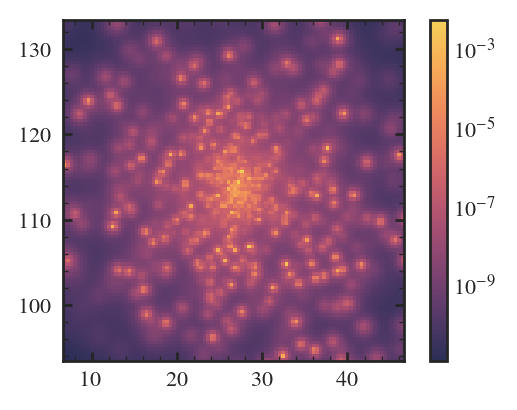

In [73]:
img = density.reshape(N, N)
plt.imshow(img, norm=mpl.colors.LogNorm(np.min(density), np.max(density)), origin="lower", extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
plt.colorbar()

In [83]:
lguys.image.mag_image?

Signature: lguys.image.mag_image(x, y, im_kwargs={}, **kwargs)
Docstring: <no docstring>
File:      ~/dwarfs/lilguys/image.py
Type:      function


In [ ]:
lguys.image.mag_image(snap_i.x, snap_i.y, bins=50, range=([10, 40], [100, 125]), vmin=0.01, eta=100, cmap="arya")
plt.colorbar()

In [74]:
snap_i.epsilon=0.1
density = rho(snap_i, X)

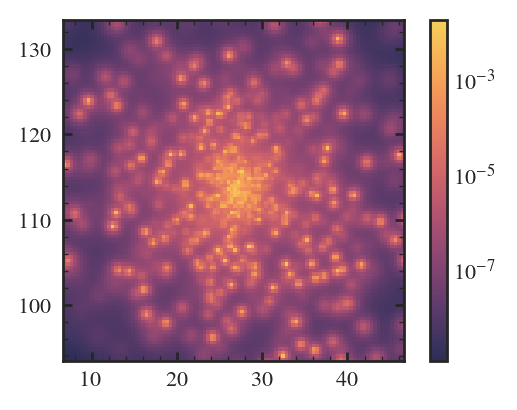

In [75]:
img = density.reshape(N, N)
plt.imshow(img, norm=mpl.colors.LogNorm(np.min(density), np.max(density)), origin="lower", extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
plt.colorbar()

In [76]:
snap_i.epsilon=1
density = rho(snap_i, X)

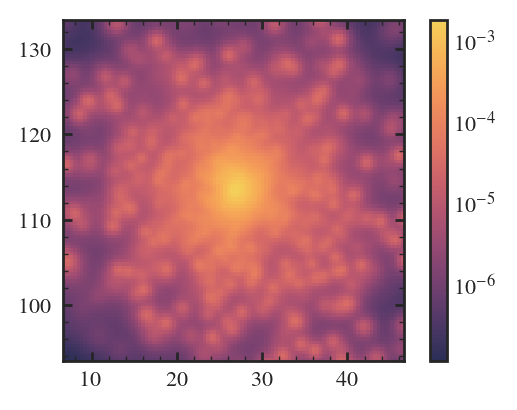

In [77]:
img = density.reshape(N, N)
plt.imshow(img, norm=mpl.colors.LogNorm(np.min(density), np.max(density)), origin="lower", extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
plt.colorbar()

(15.0, 35.0)

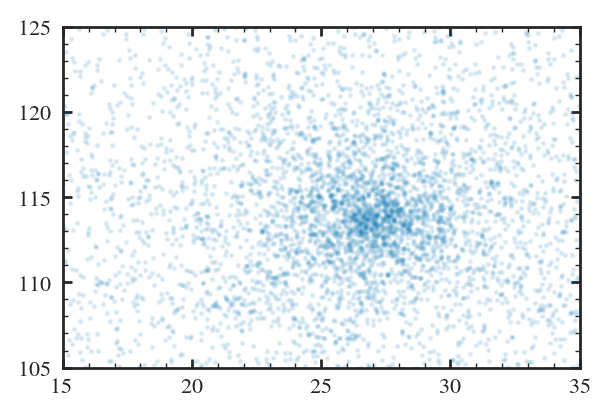

In [67]:
plt.scatter(snap_i.x, snap_i.y, alpha=0.1, s =1)
plt.ylim(105, 125)
plt.xlim(15, 35)

In [7]:
snap_i = out3[10]
snap_f = out3[-1]

In [8]:
snap_i = lguys.profile.center_snapshot(snap_i)

In [36]:
snap3 = lguys.Snapshot.file("../mw_models/fornax/orbit_3.hdf5")

/cosma/home/durham/dc-boye1/dwarfs/lilguys/profile.py:16: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(r>0, np.sqrt(G*M/r), 0)
/cosma/home/durham/dc-boye1/dwarfs/lilguys/profile.py:16: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(r>0, np.sqrt(G*M/r), 0)
/cosma/home/durham/dc-boye1/dwarfs/lilguys/profile.py:16: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(r>0, np.sqrt(G*M/r), 0)
/cosma/home/durham/dc-boye1/dwarfs/lilguys/profile.py:16: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(r>0, np.sqrt(G*M/r), 0)


Text(0, 0.5, '$V_{\\rm circ}(r) / {\\rm km\\,s}^{-1}$')

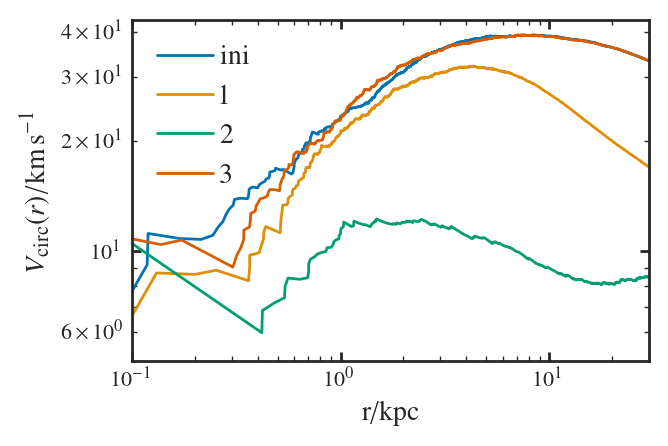

In [214]:

for i in range(4):
    snap = [out[1], out[-1], out2[-40], out3[0]][i]
    snap = lguys.profile.sort_r(lguys.profile.center_snapshot(snap))
    vc = lguys.profile.V_circ(snap.m*(1+np.arange(len(snap))), snap.r)
    plt.plot(snap.r, vc*lu.V_0, label = ["ini", 1, 2, 3][i])

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1, 30)
plt.ylim(5)
plt.xlabel("r/kpc")
plt.ylabel(r"$V_{\rm circ}(r) / {\rm km\,s}^{-1}$")

In [142]:
r_hl = 0.949

In [24]:
lguys.profile.V_r(snap_i, r_hl)

array(0.18690213)

In [143]:
def get_Vmax_x(output):
    snap_xs = np.empty((output.Nt, 3))
    v_max = np.empty((output.Nt))
    v_hl = np.empty(output.Nt)
    
    for i in range(output.Nt):
        snap = output[i]
        p0, v0 = lguys.profile.get_center(snap)
        snap = lguys.profile.center_snapshot(snap, verbose=False)
        snap_xs[i] = p0
        v_max[i] = lguys.profile.get_Vmax(snap)
        v_hl[i] = lguys.profile.V_r(snap, r_hl)

    return v_max, v_hl, snap_xs

In [144]:
v1, vh1, x1 = get_Vmax_x(out)

In [36]:
v3, vh2, x3 = get_Vmax_x(out3)

In [37]:
v2, vh3, x2 = get_Vmax_x(out2)

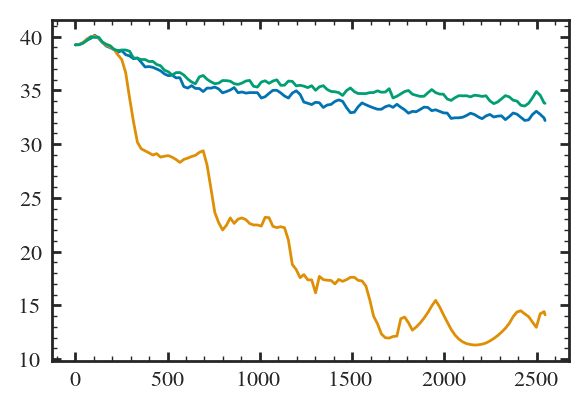

In [32]:
plt.plot(out.t, v1*lu.V_0)
plt.plot(out2.t, v2*lu.V_0)
plt.plot(out3.t, v3*lu.V_0)


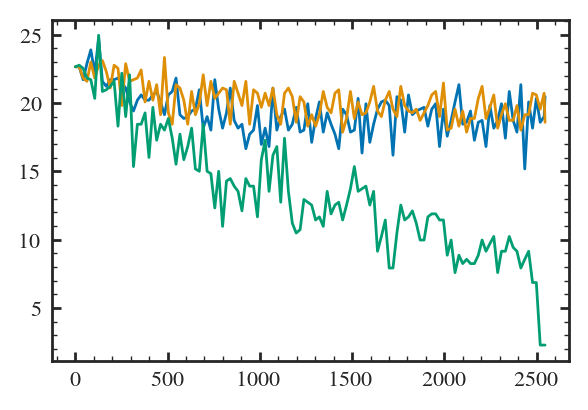

In [38]:
plt.plot(out.t, vh1*lu.V_0)
plt.plot(out2.t, vh2*lu.V_0)
plt.plot(out3.t, vh3*lu.V_0)

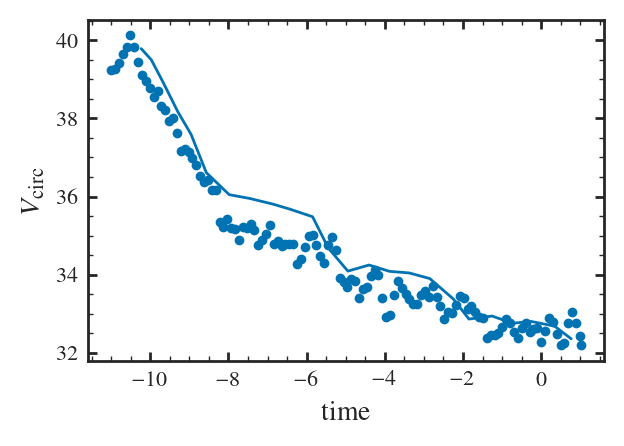

In [18]:
plt.scatter(out.t*lu.T_0/1e9-11, v1*lu.V_0)

plt.plot(asya_fornax1_vmax_x, asya_fornax1_vmax_y)
plt.xlabel("time")
plt.ylabel(r"$V_{\rm circ}$")
plt.savefig("vcirc.pdf")

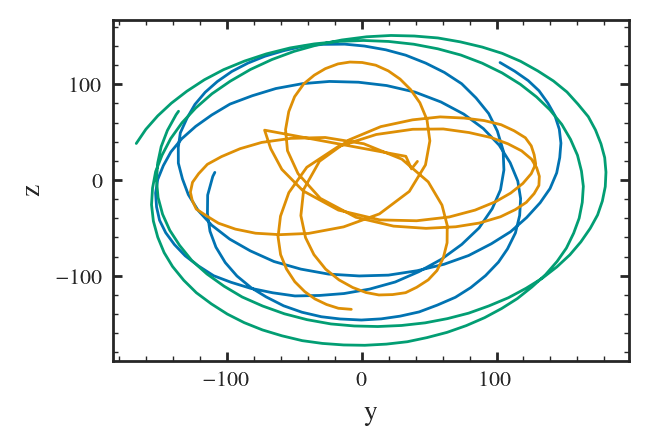

In [74]:
plt.plot(x1[:, 1], x1[:, 2])
plt.plot(x2[:, 1], x2[:, 2])
plt.plot(x3[:, 1], x3[:, 2])

plt.xlabel("y")
plt.ylabel("z")
plt.savefig("center_orbit.pdf")

In [148]:
import matplotlib.animation

In [137]:
snap0 = out[0]

MovieWriter ffmpeg unavailable; using Pillow instead.


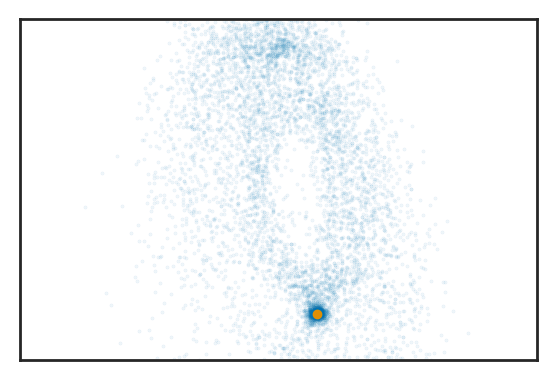

In [149]:
fig = plt.figure()

scat = plt.scatter(snap0.x, snap0.y, s=0.1, alpha=0.1)
scat1 = plt.scatter(x1[0,0], x1[0,1])

plt.xlim(-180, 160)
plt.ylim(-150, 150)
plt.xticks([])
plt.yticks([])
    
def update_fig(i, scat):
    X = out.pos[i, :, 0:2]
    scat.set_offsets(X)
    scat1.set_offsets(x1[i,0:2])
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(out.Nt),
                                  fargs=(scat,))

ani.save("orbit.gif", dpi=200)
plt.show()

In [150]:
snap_i = out[1]
snap_f = out[-1]

In [151]:
def get_mid_coord(snap):
    p0, v0 = lguys.profile.get_center(snap)
    phase = lguys.coords.phase_point(*p0, *v0)
    return lguys.coords.to_sky(phase)

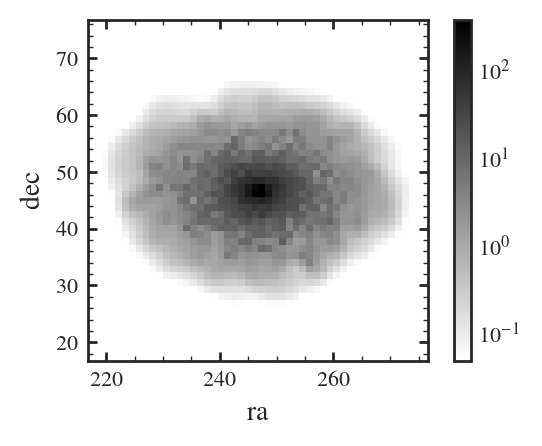

In [203]:
mid_obs = get_mid_coord(snap_i)
obs = lguys.coords.to_sky(snap_i)
d_deg = 30
ra_0 = float(mid_obs.ra)
dec_0 = float(mid_obs.dec)
x = np.array(obs.ra)
y = np.array(obs.dec)
lguys.image.mag_image(x, y, bins=50, range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)));
plt.xlabel("ra")
plt.ylabel("dec")
plt.colorbar()

plt.savefig("skyproj_init.pdf")

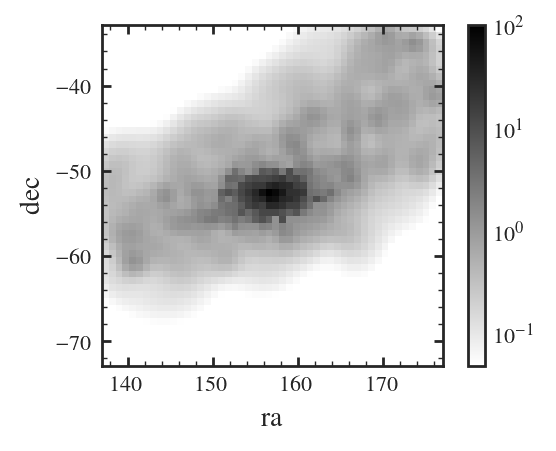

In [205]:
mid_obs = get_mid_coord(snap_f)
obs = lguys.coords.to_sky(snap_f)
d_deg = 20
ra_0 = float(mid_obs.ra)
dec_0 = float(mid_obs.dec)
x = np.array(obs.ra)
y = np.array(obs.dec)
lguys.image.mag_image(x, y, bins=50, range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)));
plt.xlabel("ra")
plt.ylabel("dec")
plt.colorbar()
plt.savefig("skyproj_fin.pdf")

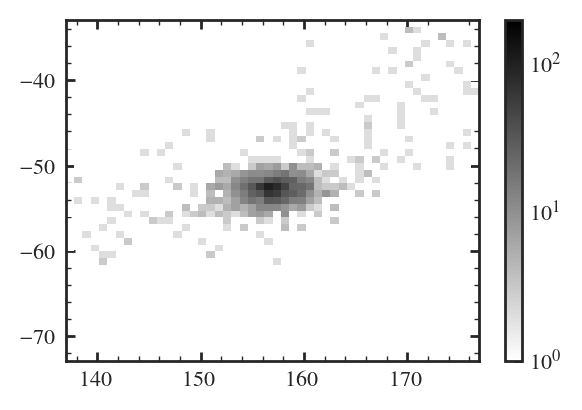

In [206]:
plt.hist2d(x, y, bins=50, range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)), cmap="gray_r", norm=mpl.colors.LogNorm(1, 200));
plt.figaspect(1)
plt.colorbar()

(-72.8909911827846, -32.890991182784596)

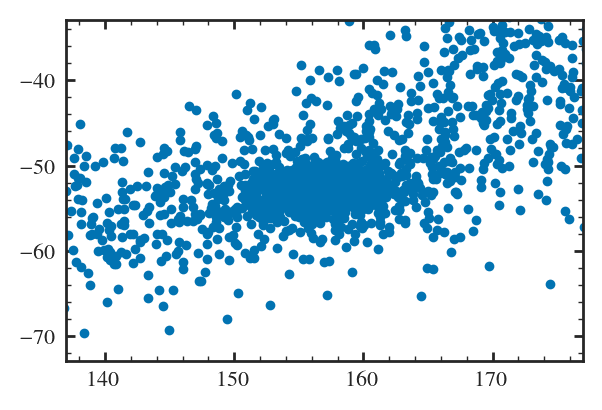

In [207]:
plt.scatter(x, y)
plt.xlim(ra_0-d_deg, ra_0+d_deg)
plt.ylim(dec_0-d_deg, dec_0+d_deg)


In [298]:
prof = lguys.profile.Profile(snap_i)
prof_f = lguys.profile.Profile(snap_f)

break radius (crossing time = time since pericenter)

rapha has code to find bound particles. iteratively compute potential and remove unboun particles to find maximally self-bound potential. spherical symmetry simplifies potential calculation.

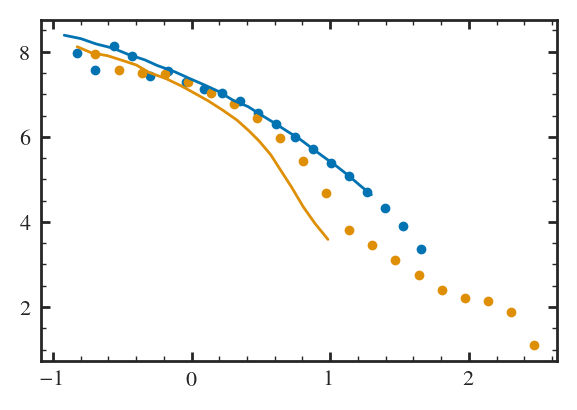

In [305]:
# check if asya only plots bound particles
plt.scatter(np.log10(prof.r), np.log10(prof.nu_DM) + 10)
plt.scatter(np.log10(prof_f.r), np.log10(prof_f.nu_DM) + 10)
plt.plot(asya_rho_dmi_x, asya_rho_dmi_y)
plt.plot(asya_rho_dmf_x, asya_rho_dmf_y)

# Calculate stellar probabilities

In [54]:
snap0 = snap_i

In [55]:
G = 1
EPSREL = 1e-7

# profile scale radius and index
n = 1
rsS = 2 # kpc, input

EN = 20
DF_Nr = 20

In [56]:
snap0 = lguys.profile.center_snapshot(snap0)

r = snap0.r

idx_sort = np.argsort(r)

m = snap0.m
N = len(r)
Mr = m * np.arange(N)

N = len(r)
Φ = snap0.potential
IDs = snap0.IDs
# Phi = -G * (Mr/r[idx_sort] + np.cumsum(m / r[idx_sort][::-1])[::-1])

In [57]:
E_kin = 1/2 * np.sum(snap0.vel**2, axis=1)
E_kin = np.array(E_kin)
Etot = E_kin + Φ[np.argsort(idx_sort)]

In [58]:
def ρ_star(r):
    return np.exp(-(r/rsS)**(1/n))

def ρ_s_int(r):
    return 4*np.pi * r**2 * ρ_star(r)

M_star = quad(ρ_s_int, 0., np.inf)[0]
M_star_r = np.vectorize(lambda x: quad(ρ_s_int, 0, x)[0])

In [59]:
DF_r_max = np.max(r)
DF_r_min = np.min(r[r > 2*EPSREL])
bins = np.logspace(np.log10(DF_r_min), np.log10(DF_r_max), num=DF_Nr)
DFr = 1/2 * (bins[1:] + bins[:-1])

In [60]:
NinS = quad(ρ_s_int, 0, DF_r_min)[0]  / M_star

NoutS = 1 - quad(ρ_s_int, 0, DF_r_max)[0]/M_star

In [63]:
psi = - np.interp(DFr, r[idx_sort], Φ)

nuDM, edges = np.histogram(r, bins=bins)
dV = (4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3))
nuDM = nuDM * m / dV

DF_rm = 1/2*(edges[1:] + edges[:-1])

In [64]:
nuS = ρ_star(DF_rm) / M_star

In [65]:
M_cum = np.interp(DF_rm, r[idx_sort], Mr)
M_star_cum = M_star_r(DF_rm)

In [66]:
M_star_cum

array([3.21410256e-03, 1.04073562e-02, 3.34239906e-02, 1.06046075e-01,
       3.30457622e-01, 1.00278034e+00, 2.92656167e+00, 8.06877029e+00,
       2.04956285e+01, 4.63748641e+01, 8.96809850e+01, 1.42326590e+02,
       1.82616183e+02, 1.98510790e+02, 2.00961767e+02, 2.01061343e+02,
       2.01061930e+02, 2.01061930e+02, 2.01061930e+02])

/tmp/ipykernel_197949/1652554652.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")


Text(0, 0.5, '$\\log_{10} \\nu$')

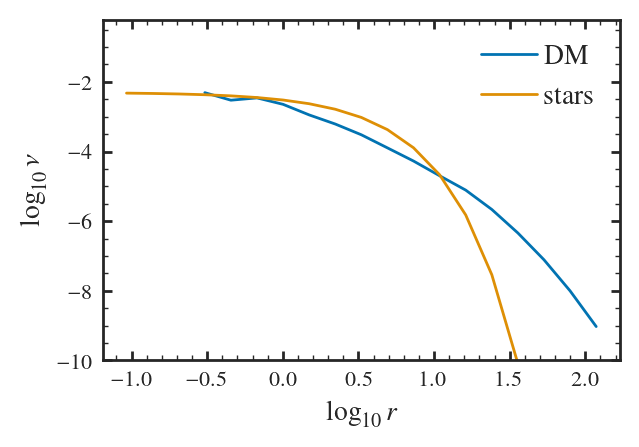

In [67]:
plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")
plt.plot(np.log10(DF_rm), np.log10(nuS), label="stars")
plt.legend()
plt.ylim(-10)
plt.xlabel(r"$\log_{10} r$")
plt.ylabel(r"$\log_{10} \nu$")

Text(0.5, 0, '$\\log r$')

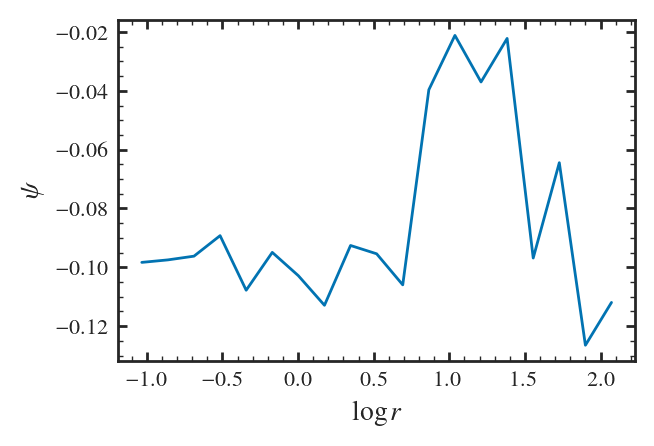

In [68]:
plt.plot(np.log10(DF_rm), -psi)
plt.ylabel(r"$\psi$")
plt.xlabel(r"$\log r$")

In [69]:
dndpDM   = np.gradient(nuDM,   psi)
d2nd2pDM = np.gradient(dndpDM, psi)
dndpS   = np.gradient(nuS,   psi)
d2nd2pS = np.gradient(dndpS, psi)

In [70]:
fS  = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pS[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(
fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) )


In [71]:
E_max = psi[0]
E_min = E_max / EN

In [72]:
E = np.linspace(E_min, E_max, EN)

In [73]:
DF_stars = fS(E)

In [74]:
DF_DM = fDM(E)

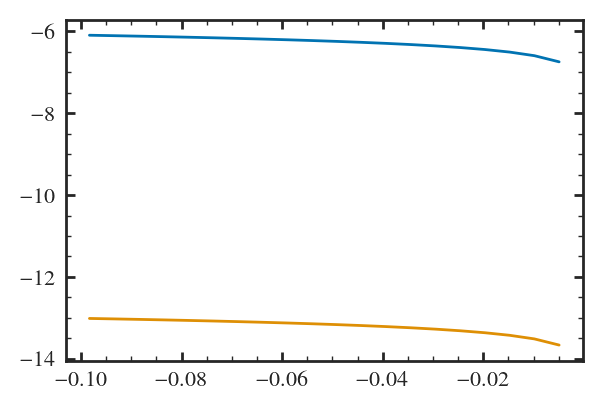

In [75]:
# plot DF vs -E
plt.plot(-E, np.log10(DF_DM))
plt.plot(-E, np.log10(DF_stars))

In [76]:
probs = np.interp(-Etot, E, DF_stars) / np.interp(-Etot, E, DF_DM)

In [77]:
probs /= np.sum(probs)

In [78]:
nuS_Nbody, edges = np.histogram(r, weights=probs, bins=bins)
nuS_Nbody = nuS_Nbody / dV

/tmp/ipykernel_197949/1322621873.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))


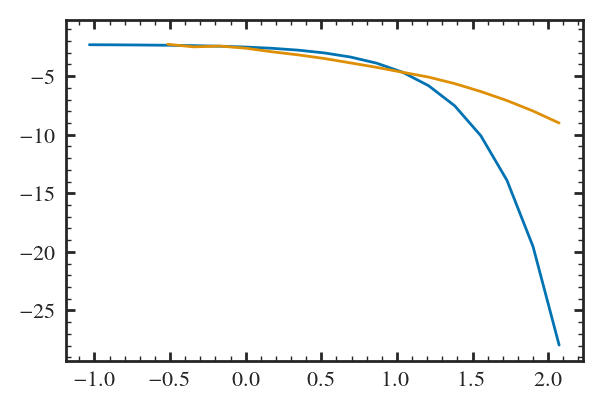

In [79]:
plt.plot(np.log10(DF_rm), np.log10(nuS))
plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))

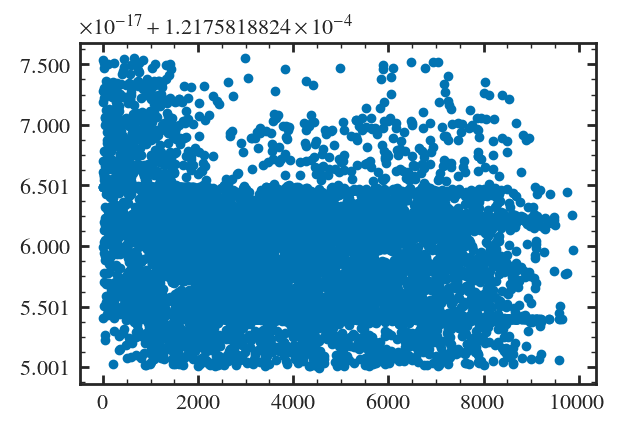

In [80]:
plt.scatter(IDs, probs)

In [87]:
Ns = 100

ID_stars = IDs[probs*Ns > np.random.uniform(size=N)]

In [88]:
ID_stars

array([3718, 1439, 7673, 5797, 7702, 7171, 8286, 5814, 7539, 8327, 8075,
       7773, 6418, 5464, 7110, 7009, 7814, 6271, 9181, 6133, 6785, 7836,
       8100, 6482, 8220, 8413, 7371, 7603, 1255, 1123,  324, 1137, 3750,
        486, 2803, 2594, 1468, 1229,  806, 1893,  946, 1516, 6945, 8688,
       7827], dtype=uint32)